In [1]:
__author__ = 'Ragadeepika Pucha <rpucha@email.arizona.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>'
__version__ = '20210802' # yyyymmdd
__datasets__ = ['sdss_dr12']  # datasets used in this notebook
__keywords__ = ['sdss', 'spectra', 'images'], # keywords relevant to this notebook from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

# Multi-wavelength Image Cutouts and SDSS Spectra of Active Galaxies with Extreme Emission-Line Ratios
*Ragadeepika Pucha (U. Arizona), Stéphanie Juneau (NOIRLab), Raphael Hviding (U. Arizona), Kevin Hainline (U. Arizona) & The Astro Data Lab Team*

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Functions](#functions)
* [Emission Lines Catalog from Portsmouth Group](#port)
* [Image Cutouts and Spectra](#plot)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
In this notebook, we show how to access and plot multiwavelength image cutouts and SDSS spectra of emission-line galaxies. We investigate outliers that have extreme [NII]/H$\alpha$ emission line ratios and compare with the results from an alternative emission line fitting routine (GELATO; Hviding et al. (in prep)).

# Summary

Studying galaxies at different wavelengths can provide us with information about their different properties. For example, the ultraviolet radiation from galaxies usually provides hints about young stellar population; the infrared emission helps us understand about old stellar population as well as the dust content of the galaxy; and so on. Radio emission in particular is significant for studying the active galactic nuclei (AGN). Synchrotron emission from the AGN can be seen via the radio imaging. Sky Surveys in different wavelength regimes thus facilitates detailed study of galaxies. 

In this notebook, we will generate image cutouts of galaxies from the surveys served in the [Legacy Survey Sky Viewer](https://www.legacysurvey.org/viewer), which range from GALEX in the ultraviolet to VLASS in the radio. This will enable us to perform visual inspection of the selected galaxies in different wavelengths. We will select galaxies from the SDSS DR12 Portsmouth Emission-Line Value-Added Catalog to identify cases with extreme line ratios, for which we will access and plot their spectra. Another Jupyter notebook titled [`01_EmLineGalaxies_SpectraStack.ipynb`](https://github.com/noaodatalab/notebooks-latest/blob/master/03_ScienceExamples/EmLineGalaxies/01_EmLineGalaxies_SpectraStack.ipynb) also uses this catalog and shows how to access mutliple spectra from SDSS and stack them.

In particular: 
- We will focus on outliers from the traditional BPT diagram ([Baldwin et al., 1981](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)). 
- We will compare the emission line flux measurements to values obtained with an alternative spectral fitting method ([GELATO](https://github.com/TheSkyentist/GELATO); Hviding et al. (in prep)).

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

Other useful references include:

* Data Lab Overview: Nikutta et al. (2020), "Data Lab-A community science platform", Astronomy and Computing, Volume 33, article id. 100411, https://ui.adsabs.harvard.edu/abs/2020A%26C....3300411N/abstract

* Project Jupyter used at Data Lab: Juneau et al. (2021), "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, https://ui.adsabs.harvard.edu/abs/2021CSE....23b..15J/abstract

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import matplotlib.backends.backend_pdf as pdf
import matplotlib

%matplotlib inline

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy.time import Time
from astropy.utils.data import download_file

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl import specClient as spec

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Authentication
# Much of the functionality of spectrum services can be accessed without explicitly logging into Data Lab (the services then uses an anonymous login). 
# But some capabilities, for instance saving the results of your queries to your virtual storage space, require a login (i.e., you will need a registered user account).

# If you need to log in to Data Lab, uncomment the 'ac.login()' command and respond according to your prompts. 
# If you have previously logged into Data Lab, this cell will simply print your active user name.

#ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

In [4]:
## Setting up plots

settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

<a class="anchor" id="functions"></a>
# Functions 

This section consists of three functions - 
1. Accessing and retrieving SDSS spectra from Data Lab
2. Accessing and retrieving image cutouts from the Legacy Survey Sky Viewer
3. Plotting the spectra and image cutouts together

In [5]:
# Function 1 -- 
# This function is the same one as in the notebook - 01_EmLineGalaxies_SpectraStack

def get_sdss_spectra(specobjid,  z, rest_frame = True):
    """
    Function to access the SDSS spectra of any object from the Data Lab specClient
    
    Returns the arrays of wavelength, flux, model and ivar.
    Returns the rest-frame arrays if rest_frame = True.
    If rest_frame = False, returns the observed-frame arrays.
    
    Parameters
    ----------
    specobjid : int64
        Unique SDSS spectrum id
        
    z : float
        Redshift of the source
    
    rest_frame : bool
        Whether or not to return the rest-frame values. Default is True.
    
    Returns
    -------
    wavelength : array
        Wavelength array (Rest-frame values if rest_frame = True)
        
    flux : array
        Flux values array (Rest-frame values if rest_frame = True)
    
    model : array
        Model values array (Rest-frame values if rest_frame = True)
        
    ivar : array
        Inverse variance array (Rest-frame values if rest_frame = True)

    """
    
    # getSpec from specClient can be used to obtain the spectra of any given object 
    # specobjid is required
    t = spec.getSpec(specobjid, fmt = 'numpy')
    
    # Extracting the different values - 
    loglam = t['loglam']       # Log wavelength
    flux = t['flux']           # Flux (f_lambda)  
    ivar = t['ivar']           # Inverse Variance
    model = t['model']         # Model
    wavelength = 10**(loglam)  # Wavelength values
    
    if rest_frame is True:
        # If rest_frame = True, we convert the different arrays into their rest-frame values
        wavelength = wavelength/(1+z)
        flux = flux*(1+z)
        model = model*(1+z)
        ivar = ivar/((1+z)**2)
    
    return (wavelength, flux, model, ivar)

We consider five different sky surveys here - 

1. GALEX (GALaxy evolution EXplorer) - This space telescope obtained direct images in the near-UV and far-UV. More information about the mission can be found [here](http://www.galex.caltech.edu/about/overview.html).

2. SDSS (Sloan Digital Sky Survey) - This optical telescope has photometry in five broad bands (*ugriz*). More information about this survey is available [here](https://www.sdss.org/).

3. DESI LS (DESI Legacy imaging Survey) - This survey comes from three optical bands (*g,r,z*). Information about the survey and about data access is available [here](https://www.legacysurvey.org/).

4. WISE (Wide-field Infrared Survey Explorer) - This space survey telescope continuously takes wide-field images of the sky in four infrared wavelength bands - 3.4, 4.6, 12 and 22 microns. Information about the mission and more can be found [here](https://www.nasa.gov/mission_pages/WISE/main/index.html). 

5. VLASS (Very Large Array Sky Survey) - This survey provides the images of the sky in the radio wavelength regime. Information about the survey is available [here](https://public.nrao.edu/vlass/).

We get the image cutouts of the galaxies through the [SkyViewer](https://www.legacysurvey.org/viewer), hosted by the Legacy Survey.

In [6]:
# Function 2

def get_image_cutouts(ra_in, dec_in, cutout_size = 60.):
    """
    Function to get the list of image cutouts in order - 'GALEX', 'SDSS', 'LS DR9', 'WISE', 'VLASS'
    
    Getting images for each of these surveys require a layername.
    To be consistent, we want to show the pixel scales to be similar to the ones from the survey.
    List of layernames and pixel scales for the surveys - 
    - GALEX - 'galex' - 1.5"/pixel
    - SDSS - 'sdss' - 0.396"/pixel
    - LS DR8 - 'ls-dr9' - 0.262"/pixel
    - WISE W1/W2 - 'unwise-neo6' - 2.75"/pixel
    - VLASS - 'vlass1.2' - 1.0"/pixel 
    
    Parameters
    ----------
    ra_in : float
        Right Ascension of the source in degrees
        
    dec_in : float
        Declination of the source in degrees
        
    cutout_size : float
        Size of the cutout in arcseconds. Default is 60 (1 arcminute in size)
        This is used along with the pixel_scale to calculate the number of pixels
        Note: The number of pixels is rounded to the nearest integer.
        So, the final cutout size may not be the exact input value, but close to it.
        
    Returns
    -------
    
    imgs: list
        List of image cutouts of the input sources in the order -
        'GALEX', 'SDSS', 'LS DR9', 'WISE', 'VLASS'
    """

    imgs = []
    
    layernames = np.array(['galex', 'sdss', 'ls-dr9', 'unwise-neo6', 'vlass1.2'])
    pixel_scales = np.array([1.5, 0.396, 0.262, 2.75, 1.0])
    pixels = cutout_size/pixel_scales
    
    for index, layername in enumerate(layernames):
        cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%.6f&dec=%.6f&layer=' %(ra_in,dec_in)+layername+'&pixscale=%g&size=%d'%(pixel_scales[index], pixels[index])
        img = plt.imread(download_file(cutout_url,cache=False,show_progress=False,timeout=120))
        imgs.append(img)
    
    return (imgs)

Matplotlib has many possible ways of creating plots. In the following function, we will use `gridspec`, which enables us to make customized subplots of varying sizes. More information is available [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html).

In [7]:
# Function 3

def plot_images_spectra(wavelength, flux, model, ivar, imgs_list, \
                          xlim = None, ylim = None, \
                          overplot_model = True, \
                          overplot_emlines = True, \
                          spectra_kwargs = {'color': 'k', 'alpha': 0.7}, \
                          model_kwargs = {'color': 'r', 'linewidth' : 2.0, 'alpha' : 0.5}):
    """
    Function to plot multi-wavelength image cutouts and SDSS spectra
    
    Parameteres
    -----------
    wavelength : numpy array
        Wavelength array of the spectra
    
    flux : numpy array
        Flux array of the spectra
        
    model : numpy array
        Model array of the spectra
        
    ivar : number array
        Inverse Variance array of the spectra
        
    imgs_list : list
        List of image cutouts of the source in oder - [GALEX, SDSS, LS DR9, WISE, VLASS]
        
    xlim : list or tuple
        Setting the xrange of the plot
        
    ylim : list or tuple
        Setting the yrange of the plot
        
    overplot_model : bool
        Whether or not to overplot the model spectrum. Default is True.
        
    overplot_emlines : bool
        Whether of not to overplot the BPT emission lines. Default is True
        
    spectra_kwargs : dict
        Plotting keyword arguments for the spectra
        
    model_kwargs : dict
        Plotting keyword arguments for the model
        
    Returns
    -------
    None 
    
    """
    
    imgs = imgs_list
    
    fig = plt.figure(figsize = (15,10), constrained_layout = True)
    gs = fig.add_gridspec(3,5)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[0,3])
    ax5 = fig.add_subplot(gs[0,4])
    ax6 = fig.add_subplot(gs[1:,:])
    ax1.set(xticks = [], yticks = [], title = 'GALEX')
    ax2.set(xticks = [], yticks = [], title = 'SDSS')
    ax3.set(xticks = [], yticks = [], title = 'LS DR8')
    ax4.set(xticks = [], yticks = [], title = 'WISE')
    ax5.set(xticks = [], yticks = [], title = 'VLASS')
    
    ax1.imshow(imgs[0])
    ax2.imshow(imgs[1])
    ax3.imshow(imgs[2])
    ax4.imshow(imgs[3])
    ax5.imshow(imgs[4])

    ax6.plot(wavelength, flux*(ivar > 0), **spectra_kwargs)
    ax6.set(xlim = xlim, ylim = ylim, xlabel = 'Wavelength ($\AA$)', ylabel = '$F_{\lambda}$ ($10^{-17}~ergs~s^{-1}~cm^{-2}~\AA^{-1}$)')
    
    if (overplot_model == True):
        ax6.plot(wavelength, model*(ivar > 0), **model_kwargs)
        
        
    if (overplot_emlines == True):
        emission_lines = [
            {"name" : "H-beta",         "lambda" : 4862.683, "emission": True,  "label" : "H$\\beta$"},
            {"name" : "[O III] 4959",   "lambda" : 4960.294, "emission": True,  "label" : "[O III]" },
            {"name" : "[O III] 5007",   "lambda" : 5008.239, "emission": True,  "label" : "[O III]" },
            {"name" : "[O I] 6300",     "lambda" : 6302.046, "emission": True,  "label" : "[O I]" },
            {"name" : "[N II] 6548",    "lambda" : 6549.859, "emission": True,  "label" : "[N II]" },
            {"name" : "H-alpha",        "lambda" : 6564.614, "emission": True,  "label" : "H$\\alpha$" },
            {"name" : "[N II] 6583",    "lambda" : 6585.268, "emission": True,  "label" : "[N II]" },
            {"name" : "[S II] 6716",    "lambda" : 6718.294, "emission": True,  "label" : "[S II]" },
            {"name" : "[S II] 6730",    "lambda" : 6732.678, "emission": True,  "label" : "[S II]" }]
        
        xbounds = ax6.get_xbound()
        
        for ii in range(len(emission_lines)):
    
            lam = emission_lines[ii]['lambda']
                
            # Plotting the emission lines if they are within the x-range of the plot
            if (emission_lines[ii]['emission']) & (lam > xbounds[0]) & (lam < xbounds[1]):
                ax6.axvline(lam, 0.95, 1.0, color = 'b', lw = 3.0)
                ax6.axvline(lam, color = 'b', lw = 1.0, linestyle = ':')
                trans = ax6.get_xaxis_transform()
                ax6.annotate(emission_lines[ii]['label'], xy = (lam, 1.05), xycoords = trans, \
                         fontsize = 16, rotation = 90, color = 'b')
                
    plt.close()
    return (fig)

<a class="anchor" id = "port"></a>
# Emission Lines Catalog from Portsmouth Group

A value added catalog (VAC) from the Portsmouth group provides information about the stellar kinematics and emission line fluxes for SDSS DR12 galaxies (`sdss_dr12.emissionlinesport`). More information about this VAC can be found [here](https://www.sdss.org/dr16/spectro/galaxy_portsmouth/#kinematics).

In this notebook, we select galaxies that have extreme line ratio [NII]/H$\alpha$ from the traditional BPT diagram ([Baldwin et. al., 1981](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)) and visually inspect their image cutouts and spectra. We define extreme as the sources that are outside the typical locus of points on the diagram. We need four emission lines - H$\alpha$$\lambda$6562, H$\beta$$\lambda$4861, [OIII]$\lambda$5006 and [NII]$\lambda$6583 - for plotting this BPT diagram. We will query these lines here along with the coordinates and redshift of the sources.

The `emissionlinesport` table contains information from the spectra of all the sources, including repeated spectra from multiple nights of observation (different MJD). In order to keep primary spectra, we JOIN this table with the `specobj` table which contains only primary spectra objects.

In [8]:
# List of emission lines we are interested in - 
emission_lines = ('Hb_4861', 'OIII_5006', 'Ha_6562', 'NII_6583')

# Creating a list of columns for all the emission lines for Flux, Flux_Err and Aon for each - 
selected_columns_sdss = ', \n'.join(['E.Flux_{0}, E.Flux_{0}_Err'.format(e) for e in emission_lines])

# Conditions - 
# Conditions on flux errors (flux errors > 0 and flux errors != Infinity)
err_cond_sdss = ' AND \n'.join(['(E.Flux_{0}_Err > 0) AND (E.Flux_{0}_Err != \'Infinity\')'.format(e) for e in emission_lines])
# Conditions on Signal to Noise ratio of all the emission lines
sn_cond_sdss = ' AND \n'.join(['(E.Flux_{0}/E.Flux_{0}_Err > 5)'.format(e) for e in emission_lines])

In [9]:
# Write a query for the emission lines from the SDSS DR12 emissionlinesport catalog
# Applying the S/N cut of >= 5 for all the four emission lines
# Also applying the conditions that all the flux errors are >0 and != infinity.
# Applying condition on redshift - only selecting galaxies with 0.02 <= z <= 0.2
# We add the mjd, plate, fiberid columns to retrieve the spectra

query = ("SELECT \nE.ra as ra_sdss, E.dec as dec_sdss, E.z,\n"+
         "E.mjd, E.plate, E.fiberid, E.chisq, \n"+
         "E.sigma_ha_6562, E.sigma_ha_6562_err, \n"+
        selected_columns_sdss+",\n"+
         "S.scienceprimary, S.specobjid, S.bestobjid \n"+
        "FROM sdss_dr12.emissionlinesport as E\n"+
        "JOIN sdss_dr16.specobj as S\n"+
        "ON (E.sdss_joinid = S.sdss_joinid) AND (E.mjd = S.mjd)\n"+
        "WHERE (E.z > 0.02) AND (E.z < 0.2) AND\n"+err_cond_sdss+" AND\n"+
        sn_cond_sdss)

In [10]:
print(query)

SELECT 
E.ra as ra_sdss, E.dec as dec_sdss, E.z,
E.mjd, E.plate, E.fiberid, E.chisq, 
E.sigma_ha_6562, E.sigma_ha_6562_err, 
E.Flux_Hb_4861, E.Flux_Hb_4861_Err, 
E.Flux_OIII_5006, E.Flux_OIII_5006_Err, 
E.Flux_Ha_6562, E.Flux_Ha_6562_Err, 
E.Flux_NII_6583, E.Flux_NII_6583_Err,
S.scienceprimary, S.specobjid, S.bestobjid 
FROM sdss_dr12.emissionlinesport as E
JOIN sdss_dr16.specobj as S
ON (E.sdss_joinid = S.sdss_joinid) AND (E.mjd = S.mjd)
WHERE (E.z > 0.02) AND (E.z < 0.2) AND
(E.Flux_Hb_4861_Err > 0) AND (E.Flux_Hb_4861_Err != 'Infinity') AND 
(E.Flux_OIII_5006_Err > 0) AND (E.Flux_OIII_5006_Err != 'Infinity') AND 
(E.Flux_Ha_6562_Err > 0) AND (E.Flux_Ha_6562_Err != 'Infinity') AND 
(E.Flux_NII_6583_Err > 0) AND (E.Flux_NII_6583_Err != 'Infinity') AND
(E.Flux_Hb_4861/E.Flux_Hb_4861_Err > 5) AND 
(E.Flux_OIII_5006/E.Flux_OIII_5006_Err > 5) AND 
(E.Flux_Ha_6562/E.Flux_Ha_6562_Err > 5) AND 
(E.Flux_NII_6583/E.Flux_NII_6583_Err > 5)


In [11]:
%%time
# It takes about 10 seconds
final_table = qc.query(sql=query, fmt = 'table')

CPU times: user 1.49 s, sys: 405 ms, total: 1.9 s
Wall time: 14.9 s


In [12]:
# Computing the logarithm of line ratios for the BPT Diagram - 

Nii_Ha = np.log10(final_table['flux_nii_6583']/final_table['flux_ha_6562'])
Oiii_Hb = np.log10(final_table['flux_oiii_5006']/final_table['flux_hb_4861'])

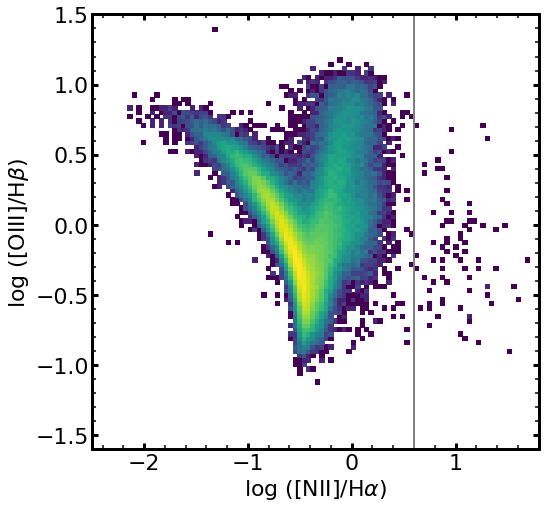

In [13]:
# Plot BPT diagram

plt.figure(figsize = (8,8))

plt.hist2d(Nii_Ha, Oiii_Hb, range = [[-2.5, 1.8], [-1.6, 1.5]], bins = 100, norm = LogNorm())
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

# add vertical line to highlight outliers with extreme [NII]/Ha ratios
plt.axvline(0.6, color = 'grey', lw = 2.0)

plt.show()

In this figure, we observe sources which are clear outliers (right of the vertical grey line). These sources have extreme [NII]/H$\alpha$ ratios. Next, we will look into the image-cutouts and spectra of some of these outlier galaxies.

In [14]:
# Selecting galaxies with log(Nii_Ha) > 0.6

sel = (Nii_Ha > 0.6)
sel_galaxies = final_table[sel]

Nsel = len(sel_galaxies)
print('There are',Nsel,'galaxies in the selection above.')

There are 78 galaxies in the selection above.


In [15]:
# Coordinates and Redshift for the selected galaxies
# These are the variables required for getting the image cutouts and the spectra

ra_sel = sel_galaxies['ra_sdss']
dec_sel = sel_galaxies['dec_sdss']
z_sel = sel_galaxies['z']

specobjid = sel_galaxies['specobjid']

<a class="anchor" id="plot"></a>
# Image Cutouts and Spectra

In [16]:
# SPECOBJIDs of objects with visible radio component: 1863420480023717888, 2085186752850454528, 4811145766419845120,
# 4934933464690741248, 6031489331591663616, 6416768651274506240,
# 6885097937309028352, 6900824802950664192 

# You can select any particular specobjid --
ii_sel = np.where(specobjid == 4934933464690741248)[0][0]
print(ii_sel)

52


You can either select a particular object based on the `specobjid` as shown in the above cell, or replace the variable `ii_sel` with a value between 0 and Nsel - 1.

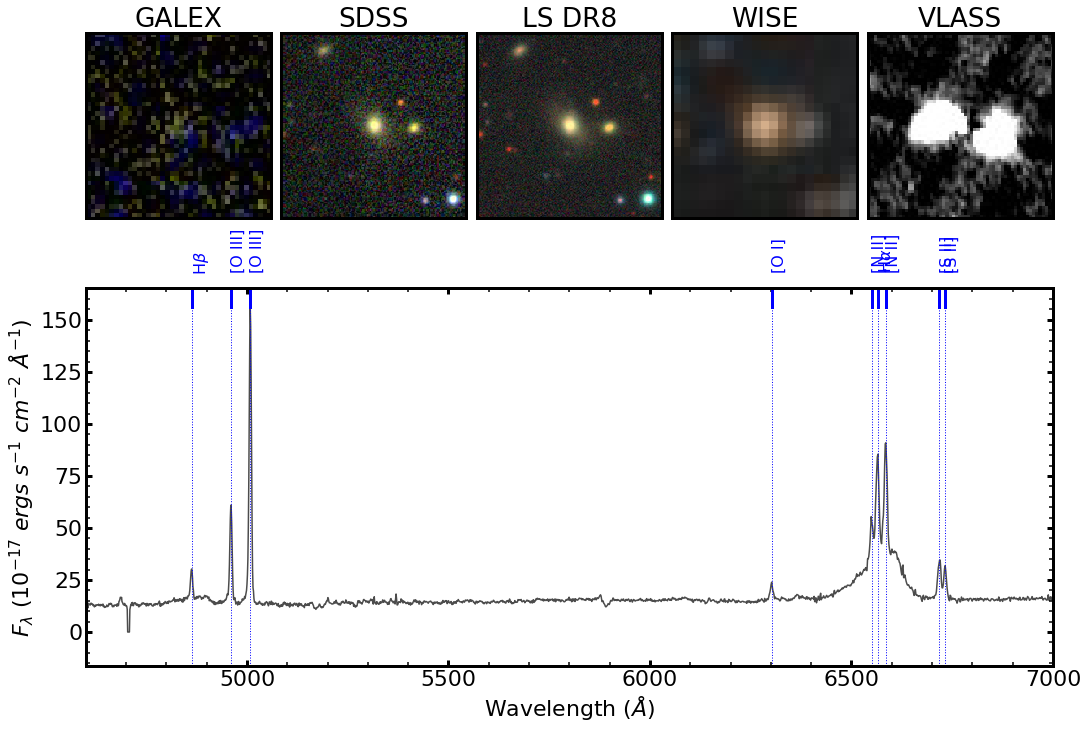

In [17]:
index = ii_sel  #or you can select any index from 0 to Nsel-1       
imgs = get_image_cutouts(ra_sel[index], dec_sel[index])
lam, flam, model, ivar = get_sdss_spectra(specobjid[index], z_sel[index])

plot_images_spectra(wavelength = lam, flux = flam, model = model, ivar = ivar, \
                    imgs_list = imgs, xlim = [4600, 7000], ylim = None, overplot_model = False)

For this particular galaxy (`specobjid == 4934933464690741248`), we make the following observations:

* Observations from the Image Cutouts:
    * The GALEX image does not show much UV emission, signalling very modest (if any) recent star formation.
    * The opical LS and SDSS images show that the galaxy has a spheroidal morphology with a possible close neighbor.
    * The WISE image shows obvious emission from the galaxy, indicating significant dust emission - this might be because of either star formation or AGN heated dust. But, since there is no GALEX emission, the AGN heated dust emission is a more likely scenario.
    * The radio emission convincingly showcases the AGN. It shows two lobes likely resulting from AGN-powered radio jets, and which do not have counterparts in other wavelength regimes.
    
    
    
* Observations from the Spectra:
    * The Balmer emission lines have both broad and narrow components - indicating a Type 1 AGN.
    * the H$\alpha$ and H$\beta$ broad components display an asymmetric profile with a significantly higher peak on the red side, which may be associated with an AGN accretion disk signature (e.g., [Storchi-Bergmann et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...835..236S/abstract))
    * There is also a clear asymmetry at the base of [OIII]$\lambda$5007, with a broadened, blue-shifted component indicating an ionized gas outflow from the AGN.

By changing the index of the object being plotted and visually inspecting the outliers, one will notice that almost all of these extreme ratio outliers have broad Balmer lines. However, the BPT diagram is designed to specifically use the narrow line flux ratios, which requires in these cases to separate the broad and narrow components. This step was not implemented in the Portsmouth emission-line catalog so the narrow line fluxes of these galaxies may not be accurate. In order to check this possibility, we have fit these spectra with [GELATO](https://github.com/TheSkyentist/GELATO), which is designed to fit emission lines in the spectra of star-forming and active galaxies (Hviding et al. (in prep)). It allows the simultaneous fitting of the broad and narrow components of emission lines, enabling a more accurate measurement of the narrow emission fluxes. 

The GELATO fit for this particular example galaxy is shown below in red (overplotted on the observed spectrum shown in grey):
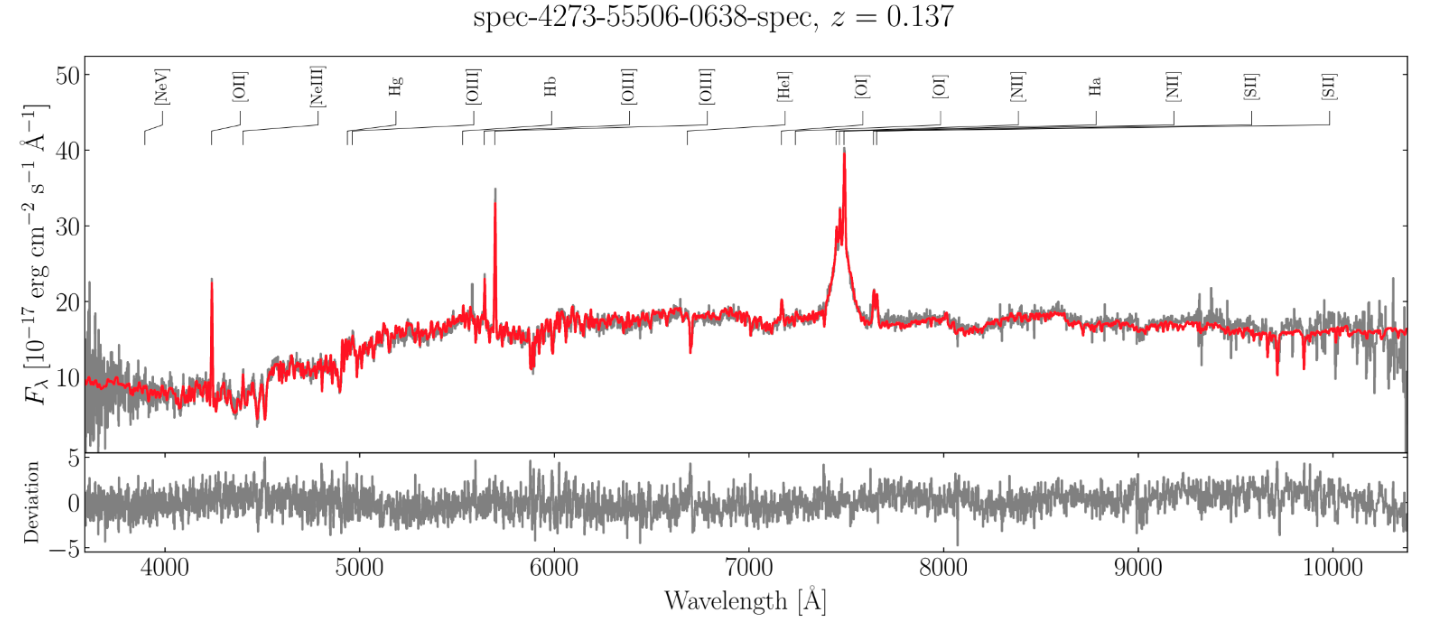

Let us now plot the BPT diagram with both the SDSS Portsmouth VAC and the GELATO flux measurements. The latter can be accessed via the `GELATO_results.fits` file distributed with this notebook.

In [18]:
gelato = Table.read('GELATO_results.fits')

oiii_gelato = gelato['Narrow-[OIII]-5006.84-Flux']
hb_gelato = gelato['Balmer-Hb-4861.28-Flux']
nii_gelato = gelato['Narrow-[NII]-6583.45-Flux']
ha_gelato = gelato['Balmer-Ha-6562.79-Flux']

oiii_hb_gelato = np.log10(oiii_gelato/hb_gelato)
nii_ha_gelato = np.log10(nii_gelato/ha_gelato)

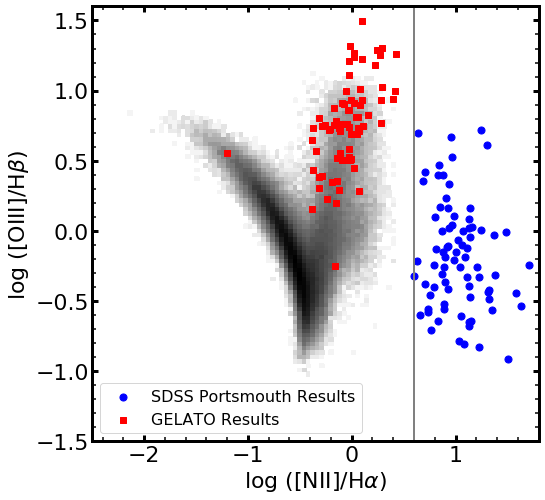

In [19]:
# Plotting the BPT diagram with SDSS (Portsmouth) and GELATO emission line fluxes -

plt.figure(figsize = (8,8))

plt.hist2d(Nii_Ha, Oiii_Hb, range = [[-2.5, 1.8], [-1.5, 1.6]], bins = 100, norm = LogNorm(), cmap = 'Greys')
plt.scatter(Nii_Ha[sel], Oiii_Hb[sel], color = 'b', marker = 'o', s = 50, label = 'SDSS Portsmouth Results')
plt.scatter(nii_ha_gelato, oiii_hb_gelato, color = 'r', marker = 's', s = 40, label = 'GELATO Results')
plt.axvline(0.6, color = 'grey', lw = 2.0)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.legend(fontsize = 16, loc = 'lower left')

plt.show()

We see that the line ratios change from the blue positions to the red positions in the BPT diagram. This indicates that emission line fluxes are not accurately measured for galaxies with broad lines such as the BPT outliers that we selected above. This work also shows that when accounting for the broad components, such as with the GELATO code, we can recover normal AGN-like ratios for the narrow components of the emission line (with the exception of one case on the BPT star-forming branch). 

---

<a class="anchor" id="resources"></a>
# Resources

- GALEX: http://www.galex.caltech.edu/about/overview.html

- SDSS: https://www.sdss.org/

- DESI Legacy imaging Survey: https://www.legacysurvey.org/

- WISE: https://www.nasa.gov/mission_pages/WISE/main/index.html

- VLASS: https://public.nrao.edu/vlass/

- Legacy Survey SkyViewer: https://www.legacysurvey.org/viewer

- Information about the galaxy properties from the Portsmouth Group: https://www.sdss.org/dr16/spectro/galaxy_portsmouth/

- Matplotlib GridSpec - https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html

- GELATO - https://github.com/TheSkyentist/GELATO


# References

- [Baldwin et. al., 1981](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)

- Hviding et al. 2021 (in prep.)

- [Storchi-Bergmann et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...835..236S/abstract)

---